Found 20940 images belonging to 7 classes.
Found 5231 images belonging to 7 classes.
Class names: ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


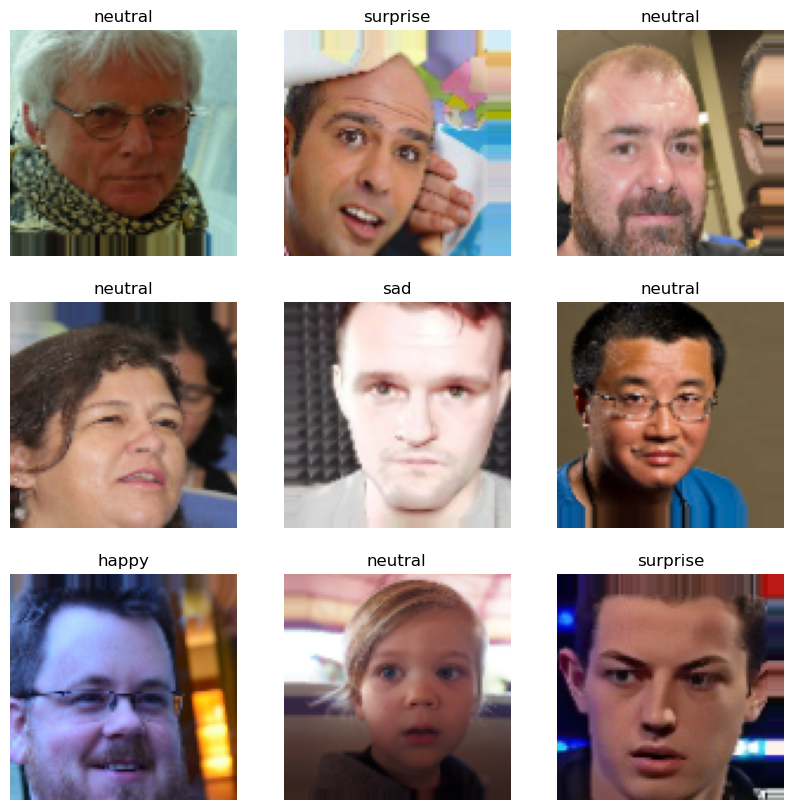

KeyboardInterrupt: 

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
# Set up data generators
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    rescale=1./255,
    validation_split=0.2 
)


train_dataset = datagen.flow_from_directory(
    r'C:\Users\hari\Videos\dataset new',  
    target_size=(96, 96),
    batch_size=200,
    class_mode='sparse',
    subset='training'  
)

validation_dataset = datagen.flow_from_directory(
    r'C:\Users\hari\Videos\dataset new',  
    target_size=(96, 96),
    batch_size=200,
    class_mode='sparse',
    subset='validation'  # Use 30% of the data for validation
)

# Display class names
class_names = list(train_dataset.class_indices.keys())
print("Class names:", class_names)

# Visualize some training images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    break
plt.show()
last_layer_index = 16
model=VGG16(weights='imagenet', include_top=False, input_shape=(96,96, 3))
for layer in model.layers:
    layer.trainable = False
x = model.layers[last_layer_index].output
x=tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(7, activation='softmax')(x)  
model = Model(inputs=model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset,epochs=20,validation_data=validation_dataset,callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(validation_dataset)
print("\nTest accuracy:", test_acc)


In [61]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # This is the gradient of the predicted class with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Pool the gradients over all the axes except the channel axis
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array by the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


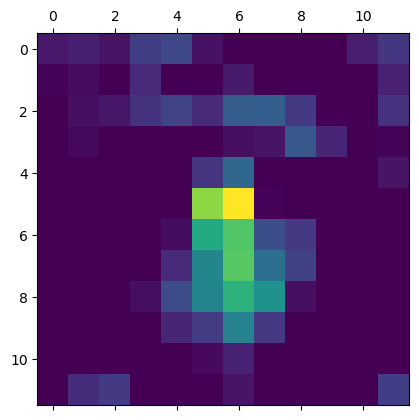

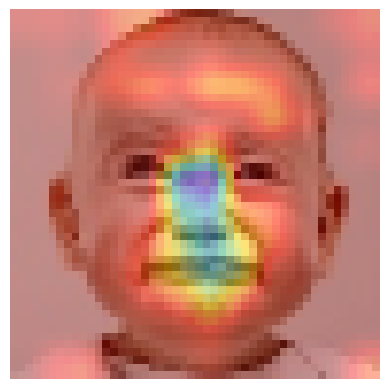

In [72]:
# Specify the layer to use for Grad-CAM
last_conv_layer_name = "block4_conv3"  # Last conv layer in VGG16

# Get an example image from the dataset
img_path = r"C:\Users\hari\Videos\dataset new\sad\image0002517.jpg"# Update with an image path from your dataset
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(96, 96))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize image

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Overlay heatmap on the original image
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load and prepare the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))  # Ensure it matches model input size
    
    # Rescale the heatmap to range 0-255 and resize it to match the input image size
    heatmap = cv2.resize(heatmap, (48, 48))
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit integer format
    
    # Apply the color map (jet) to create a colored heatmap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Ensure both images have 3 channels
    if len(img.shape) == 2:  # If the original image is grayscale, convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(jet, alpha, img, 1 - alpha, 0)
    
    # Display the image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Now call the function
display_gradcam(img_path, heatmap)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


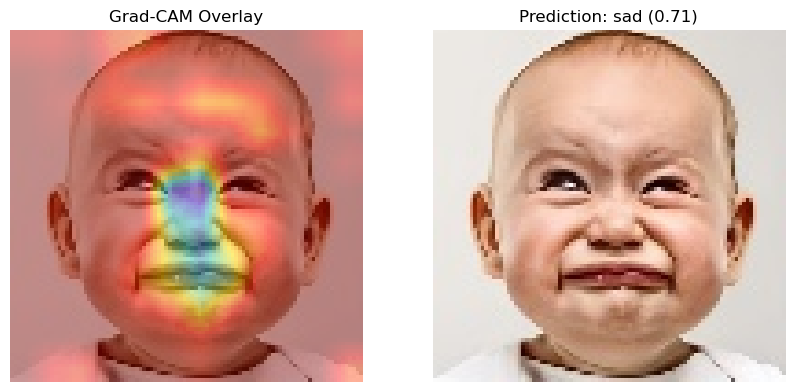

In [73]:
def display_gradcam(img_path, heatmap, model, alpha=0.4):
    # Load and prepare the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (96, 96))  # Ensure it matches model input size

    # Preprocess the image for prediction
    img_array = np.expand_dims(img / 255.0, axis=0)  # Rescale and add batch dimension

    # Get the model prediction
    preds = model.predict(img_array)
    pred_label = np.argmax(preds[0])
    confidence = preds[0][pred_label]
    
    # Convert heatmap to 0-255 range, resize to match input image
    heatmap = cv2.resize(heatmap, (96, 96))
    heatmap = np.uint8(255 * heatmap)
    
    # Apply the color map (jet) to create a colored heatmap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Ensure the original image has 3 channels if needed
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(jet, alpha, img, 1 - alpha, 0)
    
    # Display the result with prediction
    plt.figure(figsize=(10, 5))
    
    # Show the Grad-CAM overlay
    plt.subplot(1, 2, 1)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    
    # Show the prediction with label and confidence
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred_label]} ({confidence:.2f})")
    plt.axis('off')
    
    plt.show()

# Assuming class_names is already defined and contains the class names in order
display_gradcam(img_path, heatmap, model)


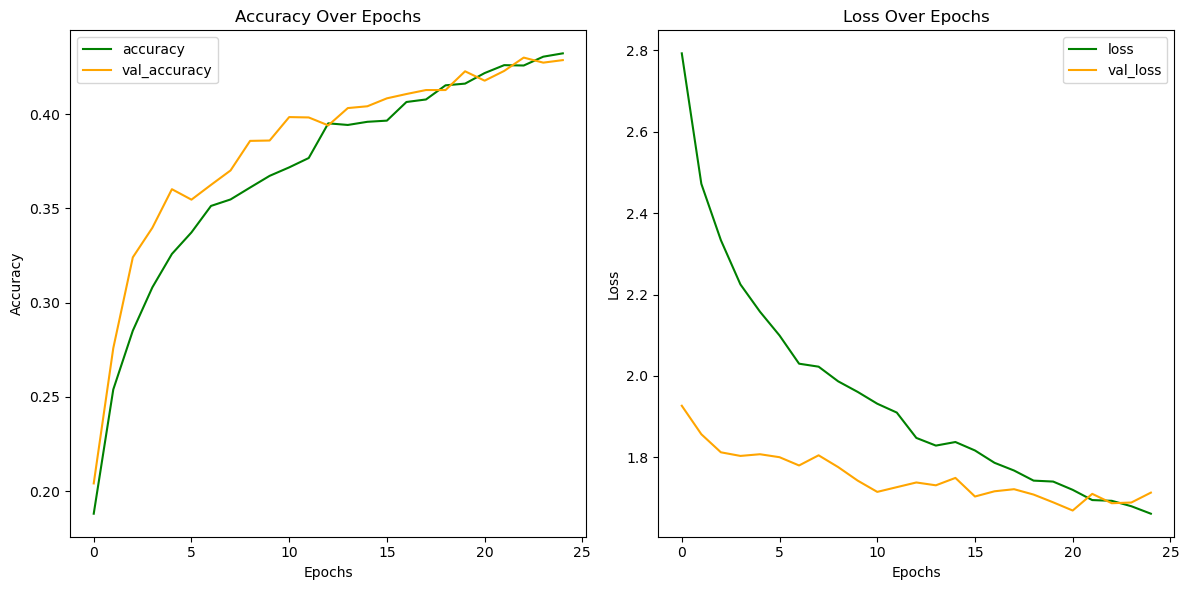

In [60]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy in the first subplot
ax[0].plot(history.history['accuracy'], color='green', label='accuracy')
ax[0].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Over Epochs')
ax[0].legend()

# Plot loss in the second subplot
ax[1].plot(history.history['loss'], color='green', label='loss')
ax[1].plot(history.history['val_loss'], color='orange', label='val_loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Over Epochs')
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [48]:
!nvidia-smi

Thu Nov  7 17:37:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   68C    P8              6W /   55W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Found 28716 images belonging to 7 classes.


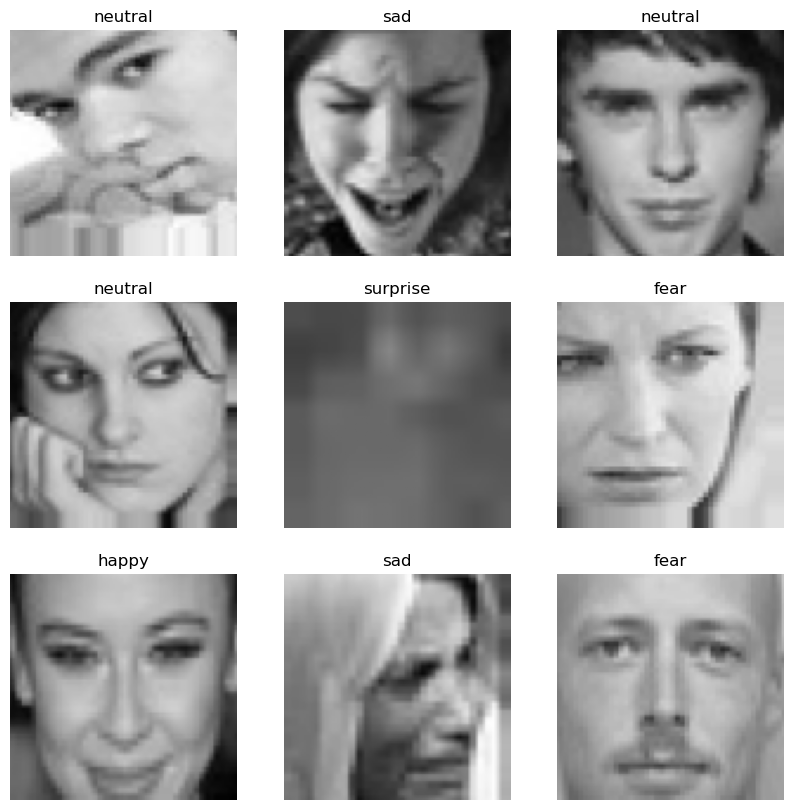

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │              

 Total params: 22,327,623 (85.17 MB)

 Trainable params: 9,969,671 (38.03 MB)

 Non-trainable params: 12,357,952 (47.14 MB)

Epoch 1/20
     29/Unknown 126s 4s/step - accuracy: 0.1452 - loss: 3.0067

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import mediapipe as mp
import cv2
import numpy as np

# MediaPipe initialization
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

def preprocess_image(image):
    # Convert float32 to uint8
    image_uint8 = (image * 255).astype(np.uint8)
    
    # Convert to RGB (already in RGB format)
    results = face_detection.process(image_uint8)
    
    if results.detections:
        detection = results.detections[0]
        bbox = detection.location_data.relative_bounding_box
        
        h, w, _ = image_uint8.shape
        x, y = int(bbox.xmin * w), int(bbox.ymin * h)
        width, height = int(bbox.width * w), int(bbox.height * h)
        
        # Ensure coordinates are within bounds
        x, y = max(0, x), max(0, y)
        width = min(width, w - x)
        height = min(height, h - y)
        
        face = image_uint8[y:y+height, x:x+width]
        face = cv2.resize(face, (96, 96))
        # Convert back to float32
        return face.astype(np.float32) / 255.0
    
    return image

# Update MediaPipeImageDataGenerator class
class MediaPipeImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        generator = super().flow_from_directory(*args, **kwargs)
        while True:
            images, labels = next(generator)
            processed_images = np.array([preprocess_image(img) for img in images])
            yield processed_images, labels

# Update data generators
train_datagen = MediaPipeImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    rescale=1./255
)

validation_datagen = MediaPipeImageDataGenerator(
    rescale=1./255
)

# Update datasets
train_dataset = train_datagen.flow_from_directory(
    'C:/Users/hari/OneDrive/Documents/fer/train',
    target_size=(96,96),
    batch_size=200,
    class_mode='sparse',
    subset='training' 

)

validation_dataset = validation_datagen.flow_from_directory(
    'C:/Users/hari/OneDrive/Documents/fer/test',
    target_size=(96, 96),
    batch_size=150,
    class_mode='sparse',
    subset='validation'
)

# Visualize some training images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    break
plt.show()
last_layer_index = 16
model=VGG16(weights='imagenet', include_top=False, input_shape=(96,96, 3))
for layer in model.layers:
    layer.trainable = False
x = model.layers[last_layer_index].output
x=tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(7, activation='softmax')(x)  
model = Model(inputs=model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset,epochs=20,validation_data=validation_dataset,callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(validation_dataset)
print("\nTest accuracy:", test_acc)